## Project Final Report

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Introduction

In [2]:
url_players<-"https://drive.google.com/uc?export=download&id=1M8-duCFfUh3MYjEn0j2WWRXzVMzTG97x"
players <- read_csv(url_players)

url_sessions <-"https://drive.google.com/uc?export=download&id=1DNxV79eDG7KkIWn6hIwgWeAeUN074SCS"
sessions <-read_csv(url_sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Methods and Results

n,min_age,max_age,mean_age,median_age,min_minutes,max_minutes,mean_minutes,median_minutes
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1439,8,50,19.39333,18,3,256,46.90896,26


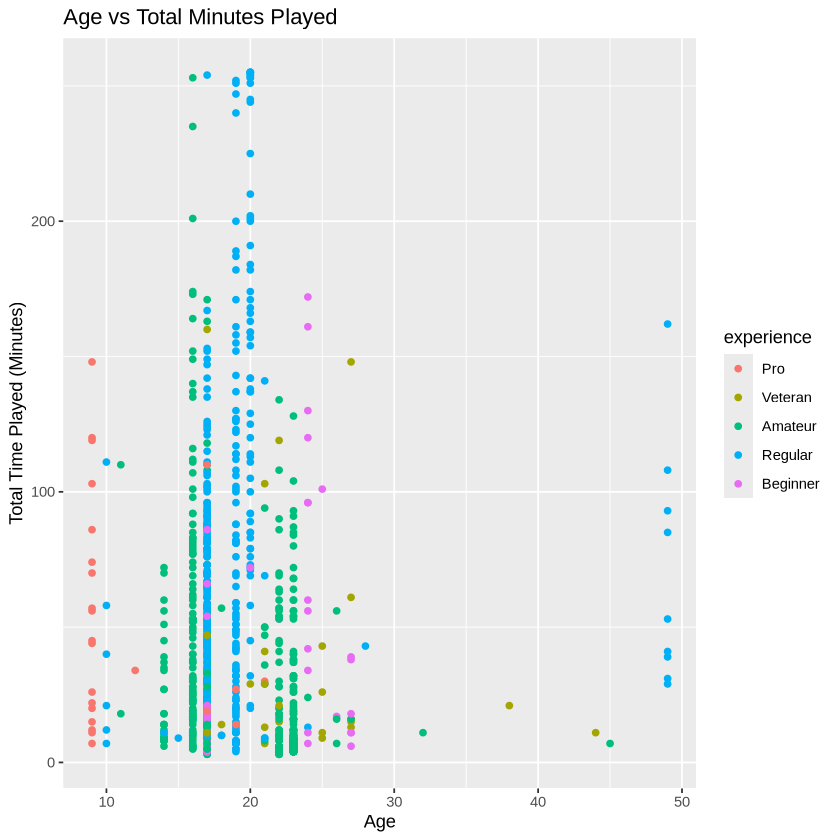

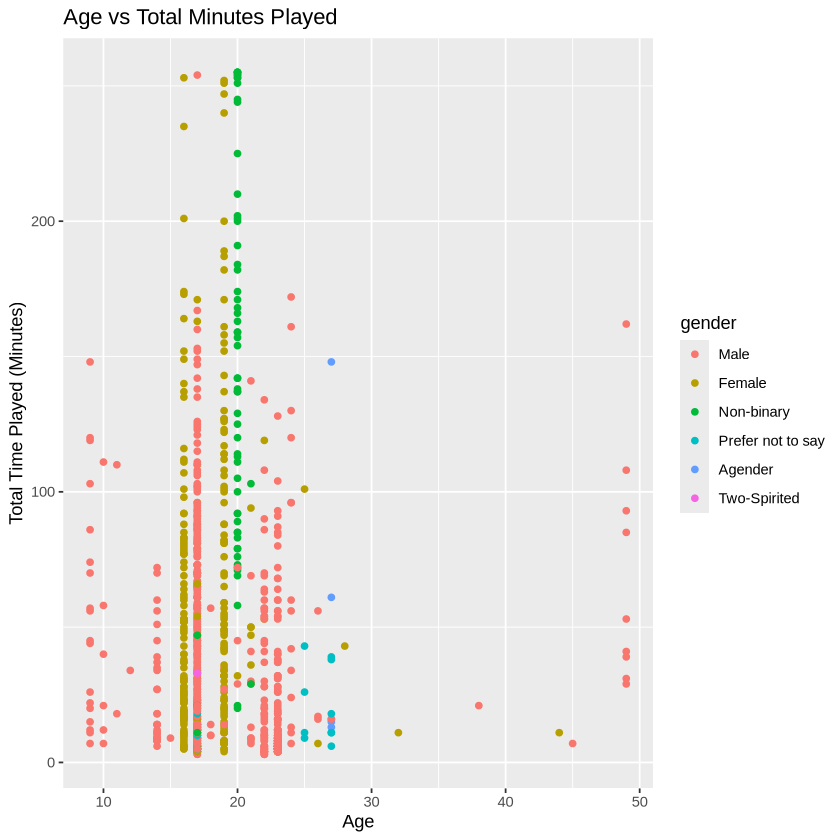

In [12]:
players_tidy<- players|>
               mutate(gender=as_factor(gender))|>
               mutate(experience= as_factor(experience))|>
               filter(!is.na(played_hours))|>
               filter(!is.na(Age))
               

tidy_sessions <- sessions |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ")|>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ")|>
    mutate(start_time = hm(start_time))|>
    mutate(end_time = hm(end_time))|>
    mutate(played_minutes = end_time-start_time)|>
    mutate(played_minutes = abs(as.numeric(played_minutes)/60))|>
    filter(played_minutes <= 1000)


data_combined<- inner_join(players_tidy, tidy_sessions, by = "hashedEmail")

data_selected<-data_combined|> select(Age, experience, played_minutes, gender)

data_summarized <- data_combined |> 
  summarise(
    n = n(),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    min_minutes = min(played_minutes, na.rm = TRUE),
    max_minutes = max(played_minutes, na.rm = TRUE),
    mean_minutes = mean(played_minutes, na.rm = TRUE),
    median_minutes = median(played_minutes, na.rm = TRUE))
data_summarized

data_split <- initial_split(data_selected, prop = 0.70, strata = played_minutes)
data_training <- training(data_split)
data_testing <- testing(data_split)
 
players_plot1<-data_training|>
               ggplot(aes(x=Age, y=played_minutes,color=experience))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Experience", title="Age vs Total Minutes Played")
players_plot1

players_plot2<-data_training|>
               ggplot(aes(x=Age, y=played_minutes,color=gender))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Gender", title="Age vs Total Minutes Played")
players_plot2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,50.14255


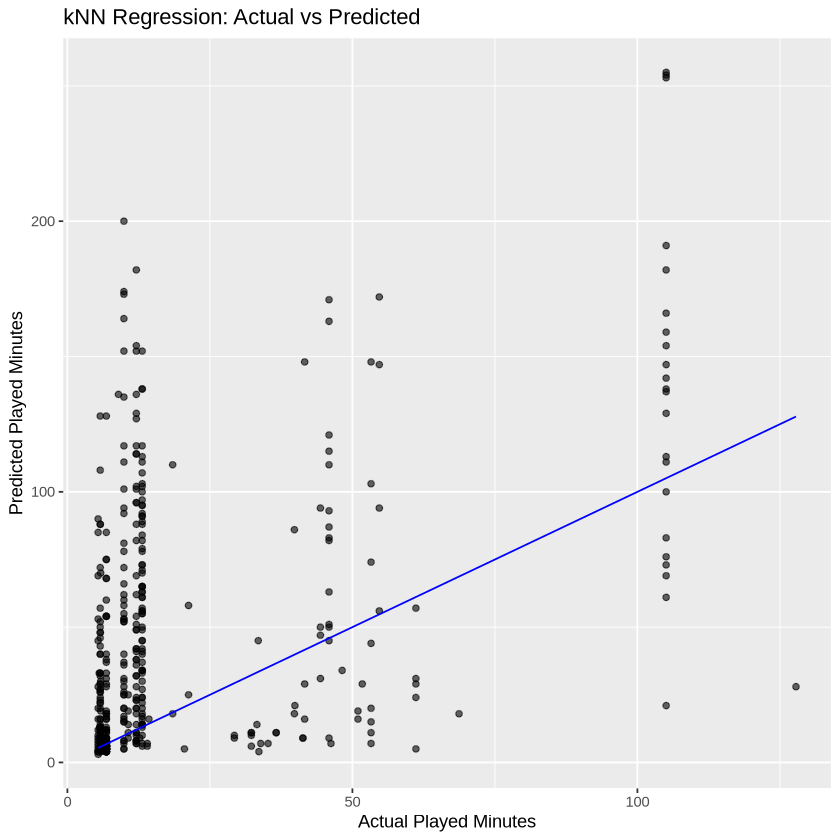

In [7]:
knn_recipe <- recipe(played_minutes ~ Age + experience + gender, data = data_training) |>
  step_dummy(all_nominal_predictors()) |> 
  step_zv(all_predictors())|>
  step_normalize(all_predictors())          

knn_model <- nearest_neighbor(mode = "regression",
  neighbors = tune() ) |>
  set_engine("kknn")


knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

folds <- vfold_cv(data_training, v=5, strata=played_minutes)

knn_grid <- grid_regular(neighbors(range = c(1,25)), levels =10)

knn_results <- tune_grid(
  knn_workflow,
  resamples = folds,
  grid = knn_grid,
  metrics = metric_set(rmse))

best_knn <- knn_results |>
  select_best(metric = "rmse")

final_knn_workflow <- finalize_workflow(knn_workflow, best_knn)

final_knn_fit <- final_knn_workflow |>
  fit(data = data_training)

final_preds <- predict(final_knn_fit, data_testing) |>
  bind_cols(data_testing)

rmse(final_preds, truth = played_minutes, estimate = .pred)

knn_plot<-ggplot(final_preds, aes(x = .pred , y = played_minutes)) +
  geom_point(alpha = 0.6) +
geom_line(data= final_preds, mapping=aes( y=.pred), color = "blue")+
  labs(x = "Actual Played Minutes", y = "Predicted Played Minutes",
       title = "kNN Regression: Actual vs Predicted")
knn_plot